**Review**

Hello Paul!

I'm happy to review your project today.
  
You can find my comments in colored markdown cells:
  
<div class="alert alert-success">
  If everything is done successfully.
</div>
  
<div class="alert alert-warning">
  If I have some (optional) suggestions, or questions to think about, or general comments.
</div>
  
<div class="alert alert-danger">
  If a section requires some corrections. Work can't be accepted with red comments.
</div>
  
Please don't remove my comments, as it will make further review iterations much harder for me.
  
Feel free to reply to my comments or ask questions using the following template:
  
<div class="alert alert-info">
  Thank you so much for your feedbacks. I've split the cells into multiple so it's easier. Hopefully i got it right this time. Thank you!
</div>
  
First of all, thank you for turning in the project! You did a great job overall, but there are some small problems that need to be fixed before the project will be accepted. Let me know if you have any questions!


# Sprint 10 Project: Integrated Project 2

## Overview

### Objective
For this project, I will create a machine learning model prototype for Zyfra, a company that develops efficiency solutions for heavy industry. The model will predict the amount of gold recovered from the processing of raw gold ore. More specifically, it will help to optimize production and eliminate unprofitable parameters.

### Workflow
For this project, I will:
- Prepare the data for analysis and modeling
- Perform data analysis across the different stages of gold purification
- Develop and train a model to predict gold recovery

## Import Libraries

In [1]:
# Import libraries required for the project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# To Create Training & Validation Sets
from sklearn.model_selection import train_test_split

# To calculate MAE
from sklearn.metrics import mean_absolute_error

# Regression Models 
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Cross Validation Score For Model Evaluation 
from sklearn.model_selection import cross_val_score

# For make_scorer to use in cross validation 
from sklearn.metrics import make_scorer

# DummyRegressor
from sklearn.dummy import DummyRegressor 

# Show all columns when displaying dataframe
pd.set_option('display.max_columns', None)

# To disbale runtime warning during model training
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

## Data Preparation

### Read Data Files

In [2]:
# Read CSVs for training and testing our model
# Additionally, the full dataset was provided
gold_recovery_train = pd.read_csv('/datasets/gold_recovery_train.csv')
gold_recovery_test = pd.read_csv('/datasets/gold_recovery_test.csv')
gold_recovery_full = pd.read_csv('/datasets/gold_recovery_full.csv')

### Recovery Calculations

The formula below is used to simulate the process of recovering gold from gold ore. In this case, the goal is to maximize the recovery coefficient ("Recovery" in the formula).

![Recovery Formula](https://practicum-content.s3.us-west-1.amazonaws.com/resources/moved_Recovery_1576238822_1589899219.jpg)

Where:
- C — share of gold in the concentrate right after flotation (for finding the rougher concentrate recovery)/after purification (for finding the final concentrate recovery)
    - This is represented in the dataset as `rougher.output.concentrate_au`
- F — share of gold in the feed before flotation (for finding the rougher concentrate recovery)/in the concentrate right after flotation (for finding the final concentrate recovery)
    - This is represented in the dataset as `rougher.input.feed_au`
- T — share of gold in the rougher tails right after flotation (for finding the rougher concentrate recovery)/after purification (for finding the final concentrate recovery)
    - This is represented in the dataset as `rougher.output.tail_au`
    
To calculate the recovery coefficient, I need to find the share of gold in the concentrate and tails.

### Calculate Recovery

In [3]:
# Create a function to calculate recovery
def recovery(df, C, F, T):
    recovery = 100 * ((df[C] * (df[F] - df[T])) / (df[F] * (df[C] - df[T])))
    return recovery

# Calculate the recovery for rows that don't have NaN in rougher.output.recovery
calculated_recovery = recovery(gold_recovery_train.dropna(subset=['rougher.output.recovery']), 'rougher.output.concentrate_au', 'rougher.input.feed_au', 'rougher.output.tail_au')

### Find MAE Between Calculated Recovery and Given Recovery (Training Dataset)

In [4]:
# Create a list of the values in 'rougher.output.recovery' from the training set
actual_recovery = gold_recovery_train['rougher.output.recovery'].dropna().to_list()

# Using the actual recovery values and the calculated recovery values, calculate the MAE
print(f"The Mean Absolute Error is {mean_absolute_error(actual_recovery, calculated_recovery)}")

The Mean Absolute Error is 9.303415616264301e-15


#### Findings

Absolute Error is the amount of error in our measurements. It is the difference between the calculated value and true value. When using our recovery function to calculate the values for recovery, the difference between our prediction and the actual results is nearly 0. This means that our function for determining recovery is accurate in calculating `rougher.output.recovery`.

<div class="alert alert-block alert-success">
<b>Reviewer's comment V1</b> <a class="tocSkip"></a>

Good job!
  
</div>

### Analysis of Features Not Available in Test Dataset

In [5]:
# Get list of features in each dataset
columns_in_train = list(gold_recovery_train.columns)
columns_in_test = list(gold_recovery_test.columns)

# Count the number of columns in the test and training set
print('The number of features in the training set is', len(columns_in_train))
print('The number of features in the test set is', len(columns_in_test))
print()

# Determine the difference in columns between the traning and the test set
difference =  gold_recovery_train[gold_recovery_train.columns.difference(gold_recovery_test.columns)].columns
print('The column count difference between the training and test set is', len(difference))
print()

# Listing the parameters and their data types
gold_recovery_train[difference].info()

The number of features in the training set is 87
The number of features in the test set is 53

The column count difference between the training and test set is 34

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 34 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         16788 non-null  float64
 1   final.output.concentrate_au                         16789 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.recovery                               15339 non-null  float64
 5   final.output.tail_ag                                16794 non-null  float64
 6   final.output.tail_au                                16794 non-null  float6

<div class="alert alert-block alert-success">
<b>Reviewer's comment V1</b> <a class="tocSkip"></a>

Correct
  
</div>

#### Findings

There are 87 columns in the training set, however there are only 53 columns in the test set. The difference of 34 columns are the product parameters (output) and calculation characteristics (calculations) of each step in the process. These outputs are not features, but instead they are targets that I can use to train our model on predict given a set of inputs at each step of the process. Because the test set doesn't have targets, and I will want to compare our predictions our target predictions of the model on the test set to actual values, I will need to use the full dataset to add targets to the test data set.

### Perform Data Preprocessing

#### Training Dataset

In [6]:
# Use print so I don't lose outputs

# Check for missing values
print('Check for Missing Values')
print(gold_recovery_train.isna().sum())
print()

# Check field with the most missing values
print('Check for Max Number of Missing Values')
print(gold_recovery_train.isna().sum().max())
print()

# Check for duplicate rows
print('Check for Duplicate Rows')
print('There are', gold_recovery_train.duplicated().sum(), 'duplicate rows')

# Check values for each column
# Commented out because output is too long in cells
print('\n Describe Dataframe')
#print(gold_recovery_train.describe())

# Check data types
print('\n Check Data Types')
print(gold_recovery_train.info())

Check for Missing Values
date                                            0
final.output.concentrate_ag                    72
final.output.concentrate_pb                    72
final.output.concentrate_sol                  370
final.output.concentrate_au                    71
                                             ... 
secondary_cleaner.state.floatbank5_a_level     85
secondary_cleaner.state.floatbank5_b_air       85
secondary_cleaner.state.floatbank5_b_level     84
secondary_cleaner.state.floatbank6_a_air      103
secondary_cleaner.state.floatbank6_a_level     85
Length: 87, dtype: int64

Check for Max Number of Missing Values
2573

Check for Duplicate Rows
There are 0 duplicate rows

 Describe Dataframe

 Check Data Types
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              -------------- 

#### Findings

- There are missing values in many of the columns within the dataset
    - Because I am uncertain on how to replace these missing values, I am going to replace them with the previous value to avoid disruption to model training. There are about ~17k values in each column and at most there are 2.5k missing values.
- Datatypes do not need to be changed
    - Date will be dropped later on when I train the model, otherwise this would need to be cast to datetime.
- There are no duplicate rows in the training set.


#### Test Dataset

In [7]:
# Use print so I don't lose outputs

# Check for missing values
print('Check for Missing Values')
print(gold_recovery_test.isna().sum())
print()

# Check field with the most missing values
print('Check for Max Number of Missing Values')
print(gold_recovery_test.isna().sum().max())
print()

# Check for duplicate rows
print('Check for Duplicate Rows')
print('There are', gold_recovery_test.duplicated().sum(), 'duplicate rows')

# Check values for each column
# Commented out because output is too long in cells
print('\n Describe Dataframe')
#print(gold_recovery_test.describe())

# Check data types
print('\n Check Data Types')
print(gold_recovery_test.info())

Check for Missing Values
date                                            0
primary_cleaner.input.sulfate                 302
primary_cleaner.input.depressant              284
primary_cleaner.input.feed_size                 0
primary_cleaner.input.xanthate                166
primary_cleaner.state.floatbank8_a_air         16
primary_cleaner.state.floatbank8_a_level       16
primary_cleaner.state.floatbank8_b_air         16
primary_cleaner.state.floatbank8_b_level       16
primary_cleaner.state.floatbank8_c_air         16
primary_cleaner.state.floatbank8_c_level       16
primary_cleaner.state.floatbank8_d_air         16
primary_cleaner.state.floatbank8_d_level       16
rougher.input.feed_ag                          16
rougher.input.feed_pb                          16
rougher.input.feed_rate                        40
rougher.input.feed_size                        22
rougher.input.feed_sol                         67
rougher.input.feed_au                          16
rougher.input.floatbank10

#### Findings

- There are also missing values in many of the columns within the dataset.
    - Similiar to the training dataset, I will replace any missing values with the previous value.
- Datatypes do not need to be changed. Date will be dropped later on when I train the model.
- There are no duplicate rows.

NOTE - Before dropping rows in the test set, I will first add in the target values from the full dataset based on date since this value isn't missing and date seems to be a primary key.

### Add Targets from Full Dataset to Test Dataset

In [8]:
# Create dataframe of values that I need to add to the test dataframe
gold_recovery_full_targets = gold_recovery_full[['date','rougher.output.recovery', 'final.output.recovery']]

# Join targets from full dataset to test dataset on date
gold_recovery_test = gold_recovery_test.merge(gold_recovery_full_targets, how ='inner', on = 'date')

# Check shape to make sure I didn't lose any rows and columns were merged
print(gold_recovery_test.shape)
print(gold_recovery_test.shape)

(5856, 55)
(5856, 55)


<div class="alert alert-block alert-success">
<b>Reviewer's comment V1</b> <a class="tocSkip"></a>

Well done!
  
</div>

### Replace Missing Values in Both Datasets

For ordered data such as what is given here, it is better to replace missing values with the previous value.

In [9]:
# Drop rows in training and test set
gold_recovery_train.fillna(method='ffill', inplace=True) 
gold_recovery_test.fillna(method='ffill', inplace=True) 

# Check for missing values in dataset after drop
print('Missing values in training data:', gold_recovery_train.isna().sum().sum())
print('Missing values in test data:', gold_recovery_test.isna().sum().sum())
print()

# Check shape of datasets after dropping rows with missing vales
print('Traning Set Shape:', gold_recovery_train.shape)
print('Test Set Shape:', gold_recovery_test.shape)

Missing values in training data: 0
Missing values in test data: 0

Traning Set Shape: (16860, 87)
Test Set Shape: (5856, 55)


<div class="alert alert-block alert-danger">
<b>Reviewer's comment V1</b> <a class="tocSkip"></a>

When you work with ML models it's almost always not a good idea to remove rows because of NaNs. When you remove a row becasue of NaN in one column, you loose information from other columns which can be usefull for model training. Thus, instead to drop NaNs it's better to fill them. So, please, do it.
    
Usually we use mean or median to fill NaNs in quantitative features. But when we have ordered data, there is a better way to fill NaNs. What is the closest value for the current one? The previous one. You can use this fact to fill NaNs in all the columns. Just read the documentation for the fillna() method and you will find a parameter which helps to fill the NaNs in such way.
  
</div>

<div class="alert alert-info">
I made this correction above.
</div>

<div class="alert alert-block alert-success">
<b>Reviewer's comment V2</b> <a class="tocSkip"></a>

Correct. Good job!
  
</div>

## Analyze the Data

Here is the basic overview of the gold purification process:

![Gold Purification Process](https://practicum-content.s3.us-west-1.amazonaws.com/resources/moved_ore_1591699963.jpg)

### Analyze Concentration Change of Metals Based on Purification Stage

Here, I will monitor the concentrations of metals (gold (Au), silver (Ag), and lead (Pb)) as the purification process progresses.

As shown in the flowchart above, the rougher concentrate undergoes two stages of purification:
- primary_cleaner - primary purification
- secondary_cleaner - secondary purification

After these purification stages, final concentrate and new tails are the result.

From a data point of view, the stages are ordered as follows:

- Metal concentration before feeding into first purification - "Initial":
    - `rougher.output.concentrate_ag`
    - `rougher.output.concentrate_pb`
    - `rougher.output.concentrate_au`
- Metal concentration after first purification stage (output of first stage and input into second stage) - "Intermediate":
    - `primary_cleaner.output.concentrate_ag`
    - `primary_cleaner.output.concentrate_pb`
    - `primary_cleaner.output.concentrate_au`
- Metal concentration after second purificaion strage (output of second purification) - "Final":
    - `final.output.concentrate_ag`
    - `final.output.concentrate_pb`
    - `final.output.concentrate_au`

Ag Concentration Change at Each Purification Step
The mean Ag concentration before primary purification is 10.54
The mean Ag concentration before secondary purification is 7.39
The mean Ag concentration after secondary purification is 4.7


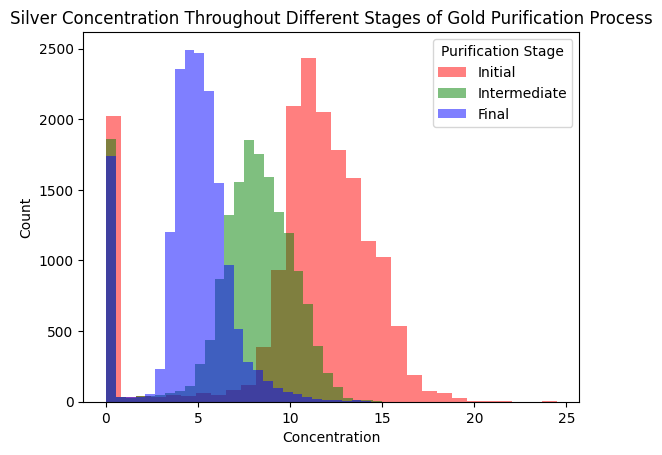


Au Concentration Change at Each Purification Step
The mean Au concentration before primary purification is 17.34
The mean Au concentration before secondary purification is 29.04
The mean Au concentration after secondary purification is 39.32


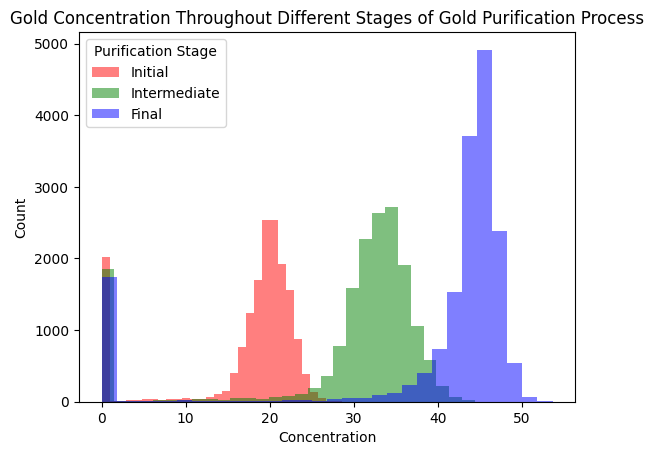


Pb Concentration Change at Each Purification Step
The mean Pb concentration before primary purification is 6.86
The mean Pb concentration before secondary purification is 8.49
The mean Pb concentration after secondary purification is 9.08


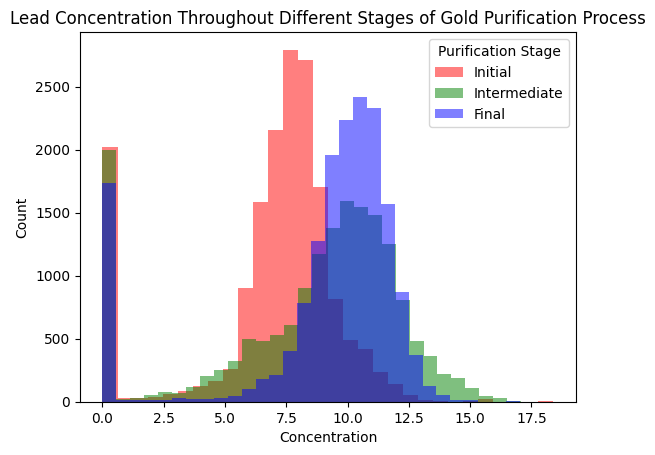

In [10]:
# Get concentrations for each metal to plot in histogram to visualize distribution of concentrations after each step

# Ag Concentation
ag_concentrations = gold_recovery_train[['rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag','final.output.concentrate_ag']]

# Au Concentation
au_concentrations = gold_recovery_train[['rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au','final.output.concentrate_au']]

# Pb Concentation
pb_concentrations = gold_recovery_train[['rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb','final.output.concentrate_pb']]

# Plot Ag Concentration Information and Histogram
print('Ag Concentration Change at Each Purification Step')
print('The mean Ag concentration before primary purification is', round(ag_concentrations['rougher.output.concentrate_ag'].mean(),2))
print('The mean Ag concentration before secondary purification is', round(ag_concentrations['primary_cleaner.output.concentrate_ag'].mean(),2))
print('The mean Ag concentration after secondary purification is', round(ag_concentrations['final.output.concentrate_ag'].mean(),2))

plt.hist(ag_concentrations['rougher.output.concentrate_ag'], color='r', bins=30, alpha=0.5, label='Initial')
plt.hist(ag_concentrations['primary_cleaner.output.concentrate_ag'], color='g', bins=30, alpha=0.5, label='Intermediate')
plt.hist(ag_concentrations['final.output.concentrate_ag'], color='b', bins=30, alpha=0.5, label='Final')
plt.title('Silver Concentration Throughout Different Stages of Gold Purification Process')
plt.ylabel('Count')
plt.xlabel('Concentration')
plt.legend(loc='upper right', title='Purification Stage')
plt.show()

print()

# Plot Au Concentration Information and Histogram
print('Au Concentration Change at Each Purification Step')
print('The mean Au concentration before primary purification is', round(au_concentrations['rougher.output.concentrate_au'].mean(),2))
print('The mean Au concentration before secondary purification is', round(au_concentrations['primary_cleaner.output.concentrate_au'].mean(),2))
print('The mean Au concentration after secondary purification is', round(au_concentrations['final.output.concentrate_au'].mean(),2))

plt.hist(au_concentrations['rougher.output.concentrate_au'], color='r', bins=30, alpha=0.5, label='Initial')
plt.hist(au_concentrations['primary_cleaner.output.concentrate_au'], color='g', bins=30, alpha=0.5, label='Intermediate')
plt.hist(au_concentrations['final.output.concentrate_au'], color='b', bins=30, alpha=0.5, label='Final')
plt.title('Gold Concentration Throughout Different Stages of Gold Purification Process')
plt.ylabel('Count')
plt.xlabel('Concentration')
plt.legend(loc='upper left', title='Purification Stage')
plt.show()

print()

# Plot Pb Concentration Information and Histogram
print('Pb Concentration Change at Each Purification Step')
print('The mean Pb concentration before primary purification is', round(pb_concentrations['rougher.output.concentrate_pb'].mean(),2))
print('The mean Pb concentration before secondary purification is', round(pb_concentrations['primary_cleaner.output.concentrate_pb'].mean(),2))
print('The mean Pb concentration after secondary purification is', round(pb_concentrations['final.output.concentrate_pb'].mean(),2))

plt.hist(pb_concentrations['rougher.output.concentrate_pb'], color='r', bins=30, alpha=0.5, label='Initial')
plt.hist(pb_concentrations['primary_cleaner.output.concentrate_pb'], color='g', bins=30, alpha=0.5, label='Intermediate')
plt.hist(pb_concentrations['final.output.concentrate_pb'], color='b', bins=30, alpha=0.5, label='Final')
plt.title('Lead Concentration Throughout Different Stages of Gold Purification Process')
plt.ylabel('Count')
plt.xlabel('Concentration')
plt.legend(loc='upper right', title='Purification Stage')
plt.show()

print()

<div class="alert alert-block alert-danger">
<b>Reviewer's comment V1</b> <a class="tocSkip"></a>

When you need to compare several distributions you need to plot them on the same graph with different colors. So, please plot 3 histograms for each metal on one graph. It total you should have 3 plots with 3 histograms on each plot.
  
</div>

<div class="alert alert-info">
I made this correction above (1 histogram per metal showing how it changes throughout each stage).
</div>

<div class="alert alert-block alert-success">
<b>Reviewer's comment V2</b> <a class="tocSkip"></a>

Well done!
  
</div>

#### Findings

- During the process of gold extraction, at each stage I notice that:
    - Silver (Ag) concentration increases after primary purification but decreases after secondary purification
    - Gold (Au) concentration increases after each stage of the purification process
    - Lead (Pb) concentration also increases after each stage of the purification process, but to a lesser degree than gold

### Comparison of Particle Size Distribution

It is a good idea to compare feed particle size distribution between training and test sets. If they vary significantly, the model will not be accurate.

Feed size refers to feed particle size. The two fields related to this parameter in the dataset are:

- `primary_cleaner.input.feed_size`
- `rougher.input.feed_size`

Particle Size Distribution For Training Set
The average particle size before the flotation step is 60.19
The average particle size before the first step of purification input is 7.3


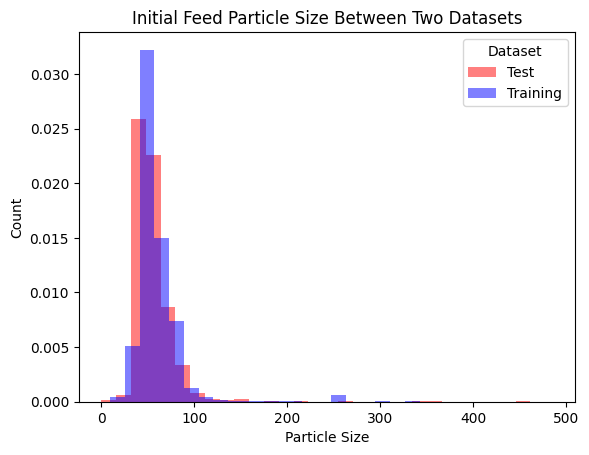


Particle Size Distribution For Test Set
The average particle size before the flotation step is 55.9
The average particle size before the first step of purification input is 7.26


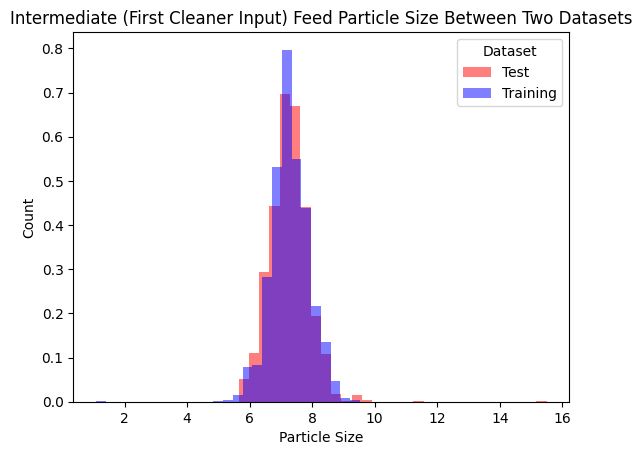

In [11]:
# Get feed sizes between train and test set
train_feed_size = gold_recovery_train[['primary_cleaner.input.feed_size','rougher.input.feed_size']]
test_feed_size = gold_recovery_test[['primary_cleaner.input.feed_size','rougher.input.feed_size']]

# Training
# Plot Particle Size Distribution For Training Set
print('Particle Size Distribution For Training Set')
print('The average particle size before the flotation step is', round(train_feed_size['rougher.input.feed_size'].mean(),2))
print('The average particle size before the first step of purification input is', round(train_feed_size['primary_cleaner.input.feed_size'].mean(),2))

plt.hist(test_feed_size['rougher.input.feed_size'], color='r', bins=30, alpha=0.5, label='Test', density=True)
plt.hist(train_feed_size['rougher.input.feed_size'], color='b', bins=30, alpha=0.5, label='Training', density=True)
plt.title('Initial Feed Particle Size Between Two Datasets')
plt.ylabel('Count')
plt.xlabel('Particle Size')
plt.legend(loc='upper right', title='Dataset')
plt.show()

# Test
# Plot Particle Size Distribution For Test Set
print()
print('Particle Size Distribution For Test Set')
print('The average particle size before the flotation step is', round(test_feed_size['rougher.input.feed_size'].mean(),2))
print('The average particle size before the first step of purification input is', round(test_feed_size['primary_cleaner.input.feed_size'].mean(),2))

plt.hist(test_feed_size['primary_cleaner.input.feed_size'], color='r', bins=30, alpha=0.5, label='Test', density=True)
plt.hist(train_feed_size['primary_cleaner.input.feed_size'], color='b', bins=30, alpha=0.5, label='Training', density=True)
plt.title('Intermediate (First Cleaner Input) Feed Particle Size Between Two Datasets')
plt.ylabel('Count')
plt.xlabel('Particle Size')
plt.legend(loc='upper right', title='Dataset')
plt.show()

<div class="alert alert-block alert-danger">
<b>Reviewer's comment V1</b> <a class="tocSkip"></a>

1. When you need to compare several distributions you need to plot them on the same graph with different colors. So, please, plot two histograms for train and test data on the same plot. It total you should have 2 plots with 2 histograms on each plot.
2. When you need to compare distributions with a different number of observations, you need to plot normalized histograms to avoid dependence on the number of observations.
  
</div>

<div class="alert alert-info">
I made this correction above.
</div>

<div class="alert alert-block alert-success">
<b>Reviewer's comment V2</b> <a class="tocSkip"></a>

Correct
  
</div>

#### Findings

- There is little to no difference between particle size for `rougher.input.feed_size` or `primary_cleaner.input.feed_size`

### Analyze Concentrations of All Substances at Different Stages

Consider the total concentrations of all substances at different stages: raw feed, rougher concentrate, and final concentrate. Do you notice any abnormal values in the total distribution? If you do, is it worth removing such values from both samples? Describe the findings and eliminate anomalies.

Text(0.5, 0.98, 'Final Concentrate Total')

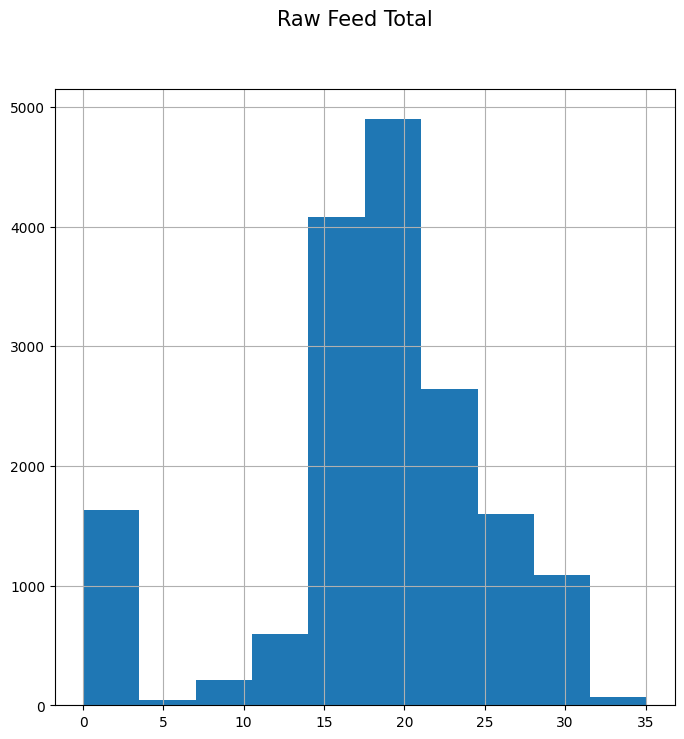

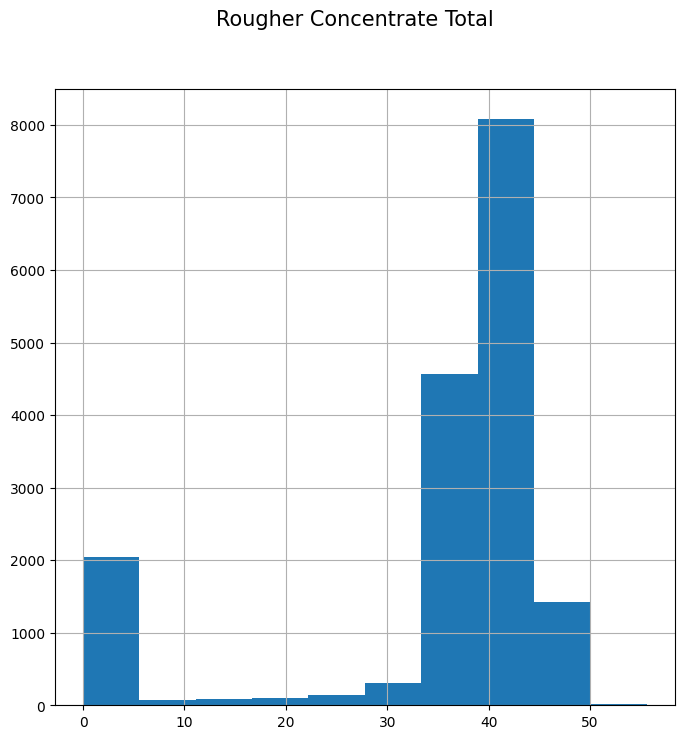

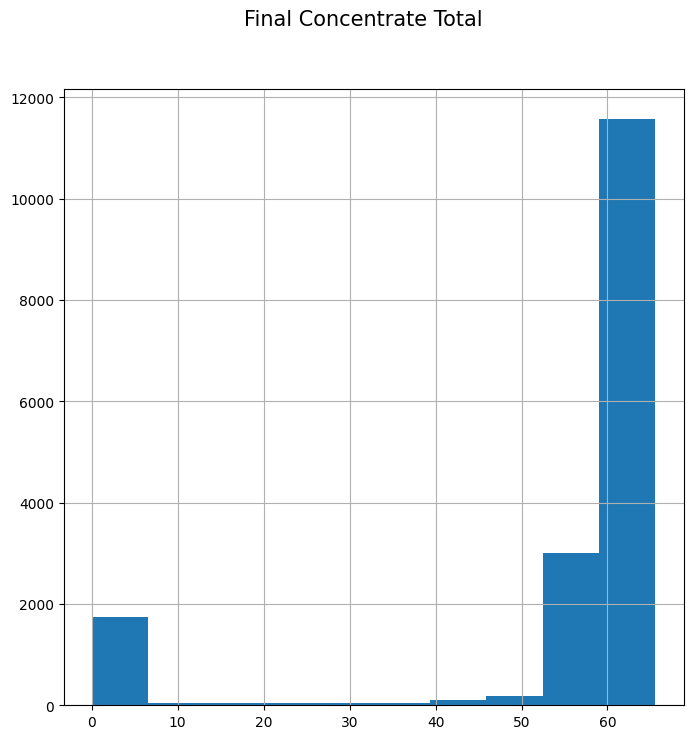

In [12]:
# Sum concentrations of metals at each stage and plot distributions

# Calculate Raw Feed Totals
# Using rougher.input.feed_
gold_recovery_train['total_raw_feed'] = gold_recovery_train[['rougher.input.feed_ag','rougher.input.feed_au','rougher.input.feed_pb']].sum(axis=1)

# Raw Feed Distribution 
fig, axis = plt.subplots(1,1,figsize=(8, 8))
gold_recovery_train['total_raw_feed'].hist(ax=axis)
fig.suptitle('Raw Feed Total', fontsize=15)



# Calculate Rougher Concentrate Totals
# Using rougher.input.feed_
gold_recovery_train['total_rough_concentrate'] = gold_recovery_train[['rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_au']].sum(axis=1)

# Raw Feed Distribution 
fig, axis = plt.subplots(1,1,figsize=(8, 8))
gold_recovery_train['total_rough_concentrate'].hist(ax=axis)
fig.suptitle('Rougher Concentrate Total', fontsize=15)



# Calculate Final Concentrate Totals
# Using rougher.input.feed_
gold_recovery_train['total_final_concentrate'] = gold_recovery_train[['final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_au']].sum(axis=1)

# Raw Feed Distribution 
fig, axis = plt.subplots(1,1,figsize=(8, 8))
gold_recovery_train['total_final_concentrate'].hist(ax=axis)
fig.suptitle('Final Concentrate Total', fontsize=15)

<div class="alert alert-block alert-success">
<b>Reviewer's comment V1</b> <a class="tocSkip"></a>

Everything is correct. Well done!
  
</div>

#### Describe Findings and Eliminate Anomalies

From looking at the each of the total distributions in the histograms, it looks like the variance of the data decreases at each stage. For example, there is a much wider variance when looking at raw feed total compared to the final concentrate total. This might be because the gold extraction process generally produces a similiar final concentration no matter the composition of the raw feed. 

Outside of this, I don't see any anomalies to remove from the dataset.

## Building the Model

I need to build a model that predicts two values:

- rougher concentrate recovery (`rougher.output.recovery`)
- final concentrate recovery (`final.output.recovery`)

Because I am trying to predict a value, and not a classification (0 or 1), I am going to test and evaluate several regression models on the training data before making a recomendation on what model type to works best for prediciting gold extraction concentrations.

### Write a Function to Calculate Final sMAPE Value

About sMAPE (Symmetric Mean Absolute Percentage Error):
- Designed to account for the relative difference between predicted and actual values, considering their magnitudes in a balanced manner. 
- Unlike other error measures, sMAPE assigns equal weight to overestimations and underestimations.

The resulting sMAPE values range from 0% to 100%, with lower values indicating higher accuracy. A sMAPE value of 0% signifies a perfect alignment between the forecasted and actual values, while a value of 100% implies no similarity between the two.

The formula for calculating sMAPE is defined in the formula below, and the parameters are defined as:

- y<sub>i</sub> - Value of target for the observation with the i index in the sample used to measure quality
- ŷ<sub>i</sub> - Value of prediction for the observation with the i index, for example, in the test sample
- N - Number of observations in the sample
- Σ - Summation over all observations of the sample (i takes values from 1 to N).

![sMAPE](https://practicum-content.s3.us-west-1.amazonaws.com/resources/moved_smape_1576238825_1589899257.jpg)

Taking into account the gold purification process, I will apply sMAPE in the following way to determine the accuracy of the model:

![Final sMAPE](https://practicum-content.s3.us-west-1.amazonaws.com/resources/moved__smape_1589899561.jpg)

In [13]:
# Create function to calculate sMAPE
def smape(true_value, predicted_value):
    smape = np.nanmean(abs(predicted_value - true_value) / ((abs(true_value) + abs(predicted_value)) / 2)) * 100 
    return smape

# Create function to calculate final sMAPE
def final_smape(true_value, predicted_value):
    predicted_rough, predicted_final = predicted_value[:, 0], predicted_value[:, 1]
    true_rough, true_final = true_value[:, 0], true_value[:, 1]
    fsmape = (.25 * (smape(true_rough, predicted_rough))) + (.75 * (smape(true_final, predicted_final)))
    return fsmape

### Train Different Regression Models and Evalulate Using Cross-Validation

#### Split Training and Test Datasets into Features and Target Datasets

In [14]:
# Create target and feature datasets using training set
# The variable difference from Section 3.3

# Remove rows from test and train where the targets are 0 to avoid division by 0 warning in sMAPE calculation
gold_recovery_train = gold_recovery_train[(gold_recovery_train['final.output.recovery'] > 0) | (gold_recovery_train['rougher.output.recovery'] > 0)]
gold_recovery_test = gold_recovery_test[(gold_recovery_test['final.output.recovery'] > 0) | (gold_recovery_test['rougher.output.recovery'] > 0)]

# Training ########################################

# Filter the fields in the training dataset to those in the test set
# Also drop date

features_train = gold_recovery_train[gold_recovery_test.columns]
#features_train = gold_recovery_train.drop(difference, axis = 1).reset_index(drop=True)
features_train = features_train.drop(['date','rougher.output.recovery', 'final.output.recovery'], axis = 1).reset_index(drop=True)

# Training Target
target_train = gold_recovery_train[['rougher.output.recovery', 'final.output.recovery']].reset_index(drop=True)


# Test ########################################

# Create features_test and target_test
# Test Features
features_test = gold_recovery_test.drop(['date','rougher.output.recovery', 'final.output.recovery'], axis = 1).reset_index(drop=True)

# Test Target
target_test = gold_recovery_test[['rougher.output.recovery', 'final.output.recovery']].reset_index(drop=True)

# Print Shape of Training & Test Data
print('Training Dataset')
print(features_train.shape)
print(target_train.shape)
print()
print('Test Dataset')
print(features_test.shape)
print(target_test.shape)

Training Dataset
(16801, 52)
(16801, 2)

Test Dataset
(5853, 52)
(5853, 2)


#### Cross-Validation Method for Training Models

Before training the models, I want to add some context on how `cross_val_score` will be used in the training our regression models. `cross_val_score` is a function that generates a cross-validated accuracy score for each data point of our dataset. It splits the data set into multiple subsets of training and testing data, trains the model on each training subset, performs predictions on the testing subset, and outputs the prediction accuracy score for each subset. The process repeats depending on the number of cross-validation folds (cv) I have set.

By default, `cross_val_score()` will use a default scoring function for whichever model that is specified. For example, if a RandomForestClassifer is the estimator, the default scoring function is the mean overall accuracy. For most regression models, it will return the R-squared value. If I want to use a different scoring function, a custom scorer can be created using the `make_scorer()` method, and specifying the scoring metric that you want to use. **For these models, I want to score on final_smape.** To do this, I can create a scorer for the final_smape function by calling `make_scorer()`. I set the scoring parameter in the `cross_val_score` function equal to the newly created `final_smape_scorer`.

In [15]:
# Create a scorer for the regression models 
final_smape_score = make_scorer(final_smape)

#### Determine Baseline sMAPE of Training Dataset

In [16]:
# Create a baseline to compare the regression models to in terms of sMAPE
target_train_copy = target_train.copy()

# Determine the mean for each training target to compare the true training target values to 
target_train_copy['rougher.output.recovery'] = target_train['rougher.output.recovery'].mean()
target_train_copy['final.output.recovery'] = target_train['final.output.recovery'].mean()

# Run final_smape function on true target training values vs target train averages
print('Average sMAPE on Training Set Targets is')
print(final_smape(target_train.values, target_train_copy.values))

Average sMAPE on Training Set Targets is
14.2477639841856


#### Training LinearRegression Model

In [17]:
# Initialize Linear Regression Model 
lr_model = LinearRegression().fit(features_train, target_train)

# cv — number of blocks for cross-validation (by default, it's 3)
lr_scores = cross_val_score(lr_model, features_train.values, target_train.values, cv=5, scoring=final_smape_score)

# Print Average sMAPE
print('The Average sMAPE for a LinearRegression Model is:', np.nanmean(lr_scores))

# Print Scores From Cross Validation
print()
print('The sMAPE scores from each fold of cross-validation were')
print(lr_scores)

The Average sMAPE for a LinearRegression Model is: 16.061574271133217

The sMAPE scores from each fold of cross-validation were
[17.59011036 12.05853014 15.9366039  17.91656618 16.80606078]


#### Training DecisionTreeRegressor Model

In [18]:
# Create a for loop to tune the DecisionTreeRegressor model 
# I want to optimize for max_depth to get the lowest Final sMAPE
for depth in range(1, 11):
# Initialize Decision Tree Regression Model 
    dtr_model = DecisionTreeRegressor(max_depth=depth, random_state=12345).fit(features_train, target_train)

    # Perfrom cross validation with scoring
    dtr_scores = cross_val_score(dtr_model, features_train.values, target_train.values, cv=5, scoring=final_smape_score)

    # Print Scores From Cross Validation
    print()
    print('With max_depth set to', depth,'- the Average Final sMAPE was', np.nanmean(dtr_scores))
    print('sMAPE scores from subsets of cross-validation were', dtr_scores)


With max_depth set to 1 - the Average Final sMAPE was 15.007613872882454
sMAPE scores from subsets of cross-validation were [13.36112617 12.18278986 13.73530798 19.76053837 15.99830698]

With max_depth set to 2 - the Average Final sMAPE was 14.660819055433223
sMAPE scores from subsets of cross-validation were [13.94952977 11.88774409 14.33070469 18.35700397 14.77911275]

With max_depth set to 3 - the Average Final sMAPE was 14.969344468661323
sMAPE scores from subsets of cross-validation were [13.52370046 12.65856651 14.66419769 19.07046698 14.92979069]

With max_depth set to 4 - the Average Final sMAPE was 14.819518325385474
sMAPE scores from subsets of cross-validation were [13.11972597 12.41569378 15.6600817  18.32468133 14.57740885]

With max_depth set to 5 - the Average Final sMAPE was 14.976443835207059
sMAPE scores from subsets of cross-validation were [13.54747368 12.9350555  15.56656974 18.5401192  14.29300105]

With max_depth set to 6 - the Average Final sMAPE was 14.5862116

#### Training RandomForestRegressor Model

In [19]:
# Create a for loop to tune the RandomForestRegressor model 
# I want to optimize for n_estimators to get the lowest Final sMAPE
for est in range(1, 11):
    # Initialize Random Forrest Regression Model 
    rfr_model = RandomForestRegressor(n_estimators=est, random_state= 12345).fit(features_train, target_train)

    # Perfrom cross validation with scoring
    rfr_scores = cross_val_score(rfr_model, features_train.values, target_train.values, cv=5, scoring=final_smape_score)

    # Print average scores for each subset of cross validation using Decision Tree Regression Model 
    #print('The Average sMAPE for a RandomForestRegressor Model is:', np.nanmean(rfr_scores))

    # Print Scores From Cross Validation
    print()
    print('With n_estimator set to', est,'- the Average Final sMAPE was', np.nanmean(rfr_scores))
    print('sMAPE scores from subsets of cross-validation were', rfr_scores)


With n_estimator set to 1 - the Average Final sMAPE was 24.47499839695389
sMAPE scores from subsets of cross-validation were [28.95214903 23.59647034 19.40381937 23.2165201  27.20603315]

With n_estimator set to 2 - the Average Final sMAPE was 19.978069213343723
sMAPE scores from subsets of cross-validation were [19.91806229 17.15983071 18.77967496 21.96439308 22.06838502]

With n_estimator set to 3 - the Average Final sMAPE was 18.13166209997114
sMAPE scores from subsets of cross-validation were [16.87971738 18.13183224 16.68952152 20.14630173 18.81093763]

With n_estimator set to 4 - the Average Final sMAPE was 17.645084455682717
sMAPE scores from subsets of cross-validation were [15.84583065 18.87279544 15.95801036 19.3371199  18.21166593]

With n_estimator set to 5 - the Average Final sMAPE was 17.39854361588123
sMAPE scores from subsets of cross-validation were [15.85435321 18.35715994 16.46936721 18.92805589 17.38378184]

With n_estimator set to 6 - the Average Final sMAPE was 1

### Compare Results of Models

Here is the performance of each model after tuning to minimize the Final sMAPE -

- Baseline Using Mean Target Values for sMAPE - 14.25.
- LinearRegression - Average Final sMAPE of 16.06.
- DecisionTreeRegressor - Average Final sMAPE of 14.58 With max_depth set to 6.
- RandomForestRegressor - Average Final sMAPE of 16.03 With n_estimators set to 10.

Given that the DecisionTreeRegressor Model (max_depth = 6) has the lowest average Final sMAPE, and this sMAPE is lower than the baseline, this is the model that I will use to predict target values with on our test dataset.

### Use Best Model on Test Dataset

#### Use DummyRegressor to Establish Baseline Prediction

Before I evaluate the DecisionTreeRegressor model on the test data, I need to establish a baseline first so that I can determine if the model DecisionTreeRegressor is actually performing well.

To do this, I will use a DummyRegressor model which is a model that makes predictions using simple rules while ignoring the input features. In this instance, I want the DummyRegressor strategy to predict the average of the test targets so I set the strategy parameter to 'mean'. A DummyRegressor is useful to provide a sanity check and to compare performance against actual Regressor models.

In [20]:
# Get baseline sMAPE to compare chosen model to

# Checking sMAPE for median value for all predictions
# Fit model to traning data
dummy_regressor = DummyRegressor(strategy='mean').fit(features_train, target_train)

# Predict test target values
target_predictions = dummy_regressor.predict(features_test)

# Print sMAPE for DummyRegressor
print('The Average sMAPE for a DummyRegressor Model is:', final_smape(target_test.values, target_predictions))

The Average sMAPE for a DummyRegressor Model is: 12.937094935751276


#### Evaluate DecisionTreeRegressor Model Predictions Using Test Dataset

In [21]:
# Initialize Decision Tree Regression Model 
dtr_model = DecisionTreeRegressor(max_depth=6, random_state=12345).fit(features_train, target_train)

# Use Model to Predict Target Values on Scaled Test Set
predicted_test = dtr_model.predict(features_test)

# Print sMAPE for DummyRegressor
print('The Average sMAPE for a DecisionTreeRegressor Model is:', final_smape(target_test.values, predicted_test))

The Average sMAPE for a DecisionTreeRegressor Model is: 11.862555194223692


<div class="alert alert-block alert-warning">
<b>Reviewer's comment V1</b> <a class="tocSkip"></a>

Great work! Everything is correct.
    
But you don't need to call method fit() if you use cross_val_score function because your model will be trained inside the cross_val_score function several times anyway. Thus, this additional training does nothing usefull and only wastes your time.
    
</div>

<div class="alert alert-info">
Thanks - I will look into that more as I become more comfortable with some of these topics. For now I left it as is.
</div>

<div class="alert alert-block alert-success">
<b>Reviewer's comment V2</b> <a class="tocSkip"></a>

Okay, as you wish. Anyway, everything is correct now. Good job!
  
</div>

## Conclusion

Compared to the baseline results of the DummyRegressor model (12.94), the DecisionTreeRegressor produces a slightly better model performance in regards to Final sMAPE (11.86). Given these results, I would implement a DecisionTreeRegressor model with max_depth=6 for Zyfra to predict the amount of gold recovered from gold ore with the smallest mean average error between the true values and predicted values.